In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import skunk
import mordred, mordred.descriptors
import exmol as exmol
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)

IPythonConsole.ipython_useSVG = True
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#F3B562', '#6e5687', '#5C4B51']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)
toxdata = pd.read_csv('BBBP.csv')
toxdata = toxdata
toxdata.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [2]:
# make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in toxdata.smiles]

# the invalid molecules were None, so we'll just
# use the fact the None is False in Python
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]
try:
    raw_features = pd.read_pickle('raw_features.pb')
except FileNotFoundError as e:
    raw_features = calc.pandas(valid_mols, nproc=8)
    raw_features.to_pickle('raw_features.pb')

In [3]:
labels = toxdata[valid_mol_idx].p_np

In [4]:
fm = raw_features.mean()
fs = raw_features.std()
def feature_convert(f):
    f -= fm
    f /= fs
    return f

features = feature_convert(raw_features)

# we have some nans in features, likely because std was 0
features = features.values.astype(float)
features_select = np.all(np.isfinite(features), axis=0)
features = features[:, features_select]

AUC 0.914832285115304


<Figure size 1200x900 with 0 Axes>

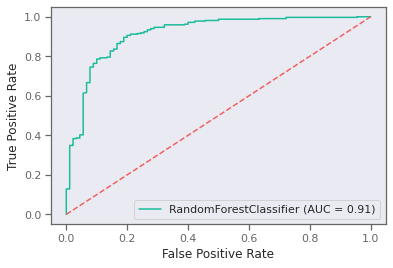

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, shuffle=True)

clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print('AUC', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
plt.figure(figsize=(4,3), dpi=300)
plot_roc_curve(clf, X_test, y_test)
plt.plot([0,1],[0,1], linestyle='--')
#plt.savefig('RF-ROC.png')

In [6]:
def model_eval(smiles, _=None):
    molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    # input wrangling. Get some weird values from weird smiles
    raw_features = calc.pandas(molecules, nproc=8, quiet=True)
    features = feature_convert(raw_features)
    features = features.values.astype(float)
    features = features[:, features_select]
    labels = clf.predict(np.nan_to_num(features))
    return labels
    #return np.random.choice([True, False], size=labels.shape)
labels = model_eval(toxdata.iloc[valid_mol_idx].smiles.values[:100])

In [7]:
example_neg = toxdata.iloc[valid_mol_idx].smiles.values[np.argmin(labels)]
example_pos = toxdata.iloc[valid_mol_idx].smiles.values[np.argmax(labels)]
example_neg_y, example_pos_y = model_eval([example_neg, example_pos])
print('neg:', example_neg, '\npos:', example_pos)
print(example_neg_y, example_pos_y)

neg: Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[C@@H](N4C3=O)C(O)=O 
pos: [Cl].CC(C)NCC(O)COc1cccc2ccccc12
0 1


In [8]:
space = exmol.sample_space(example_neg, model_eval)

🤘Done🤘: 100%|██████████| 2690.0/2690 [00:16<00:00, 164.48it/s]              


In [9]:
exps = exmol.cf_explain(space)
print(exps)

[Example(smiles='Cc1onc(-c2ccccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O', selfies='[C][C][O][N][=C][Branch1_1][Branch2_3][C][=C][C][=C][C][=C][Ring1][Branch1_2][Cl][C][Expl=Ring1][N][C][Branch1_2][C][=O][N][C][C][Branch1_2][C][=O][N][C][Ring1][Branch1_1][S][C][Branch1_1][C][C][Branch1_1][C][C][C][Ring1][Branch1_3][C][Branch1_2][C][=O][O]', similarity=1.0, yhat=0, index=0, position=array([-9.96224679,  2.16018552]), is_origin=True, cluster=-1, label=None), Example(smiles='Cc1onc(-c2ccccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2C', selfies='[C][C][O][N][=C][Branch1_1][Branch2_3][C][=C][C][=C][C][=C][Ring1][Branch1_2][Cl][C][Expl=Ring1][N][C][Branch1_2][C][=O][N][C][C][Branch1_2][C][=O][N][C][Ring1][Branch1_1][S][C][Branch1_1][C][C][Branch1_1][C][C][C][Ring1][Branch1_3][C]', similarity=0.8, yhat=1, index=202, position=array([-7.79669191, -0.09193886]), is_origin=False, cluster=27, label='Counterfactual 1'), Example(smiles='Cc1onc(-c2ccccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2CF', selfies='[C][C][O][N]

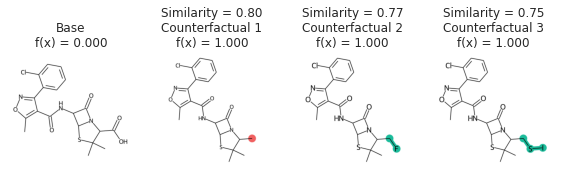

In [11]:
fkw = {'figsize': (8,6)}
mpl.rc('axes', titlesize=12)
exmol.plot_cf(exps, figure_kwargs=fkw, mol_size=(450,400), nrows=1)

plt.savefig('rf-simple.png', dpi=180)
svg = exmol.insert_svg(exps, mol_fontsize=14)
with open('svg_figs/rf-simple.svg', 'w') as f:
    f.write(svg)

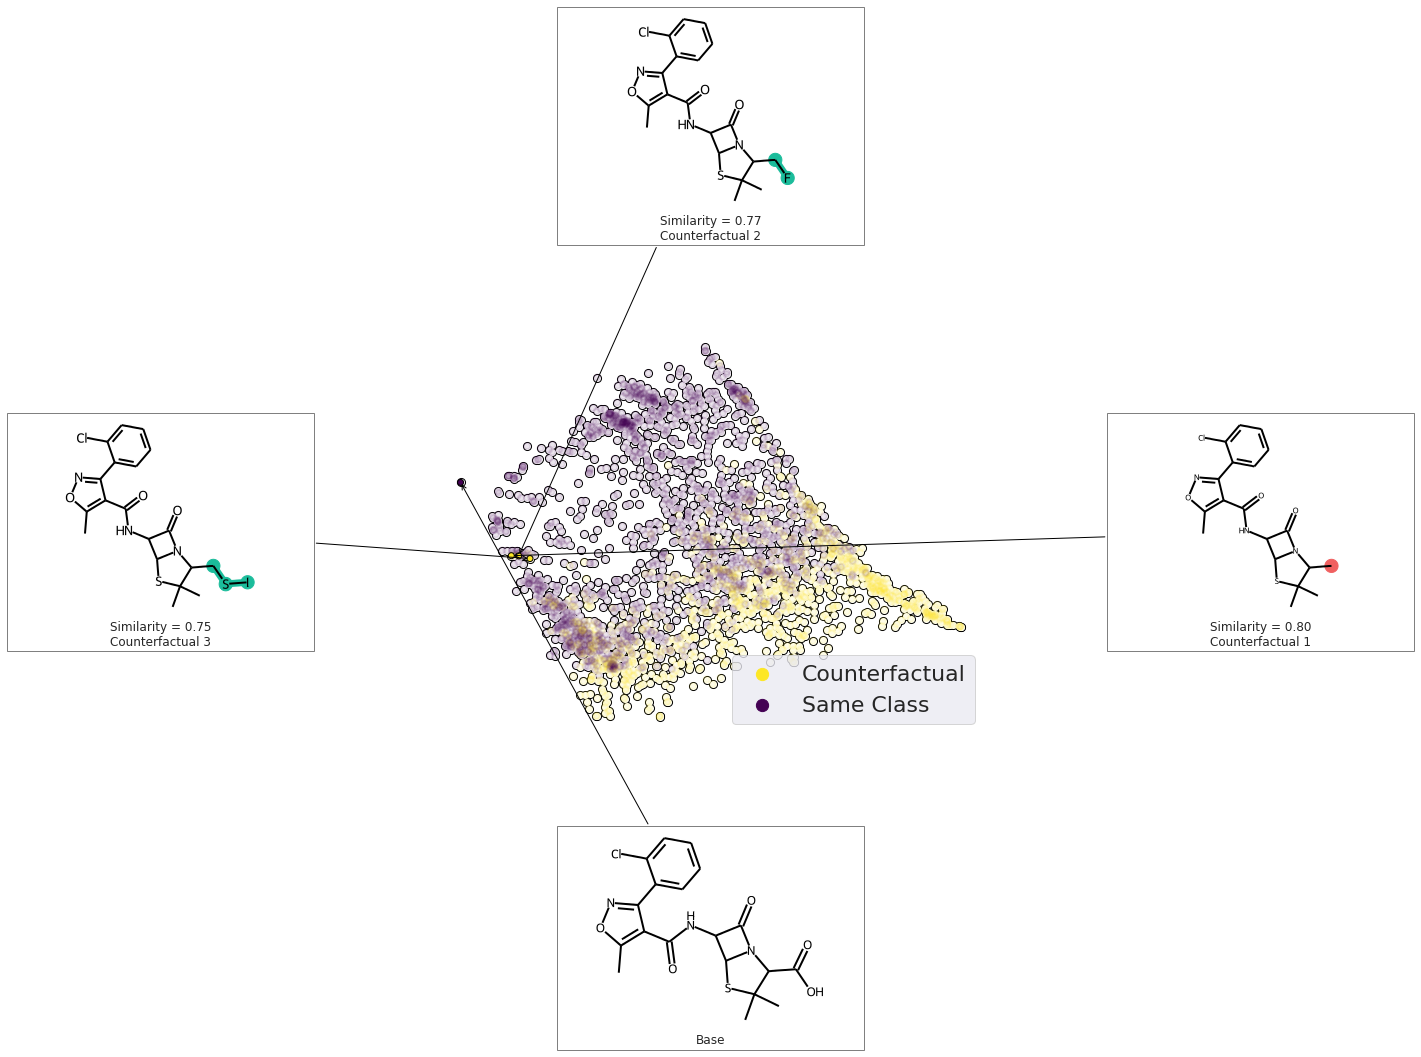

In [13]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
exmol.plot_space(space, exps, figure_kwargs=fkw, mol_size=(300,200), offset=0, cartoon=True, rasterized=True)
plt.scatter([], [], label='Counterfactual', s=150, color=plt.get_cmap('viridis')(1.0))
plt.scatter([], [], label='Same Class', s=150, color=plt.get_cmap('viridis')(0.0))
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig('rf-space.png', dpi=180)
svg = exmol.insert_svg(exps, mol_fontsize=14)
with open('svg_figs/rf-space.svg', 'w') as f:
    f.write(svg)
#skunk.display(svg)

## Schematic Plots

In [12]:
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit.Chem.Draw import MolToImage as mol2img
dos = rdkit.Chem.Draw.MolDrawOptions()
dos.useBWAtomPalette()
#dos.minFontSize = fontsize
img = mol2img(smi2mol(exps[0].smiles), options=dos)
img.save('rf-schem-1.png')

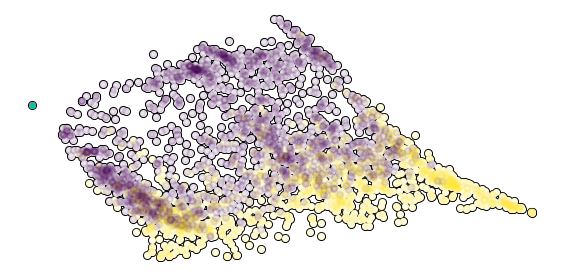

In [13]:
fkw = {'figsize': (8,4)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
exmol.plot_space(space, [], figure_kwargs=fkw, mol_size=(300,200), offset=1, cartoon=True)
plt.scatter(exps[0].position[0], exps[0].position[1])
plt.tight_layout()
plt.savefig('rf-scheme-2.png', bbox_inches='tight', dpi=180)

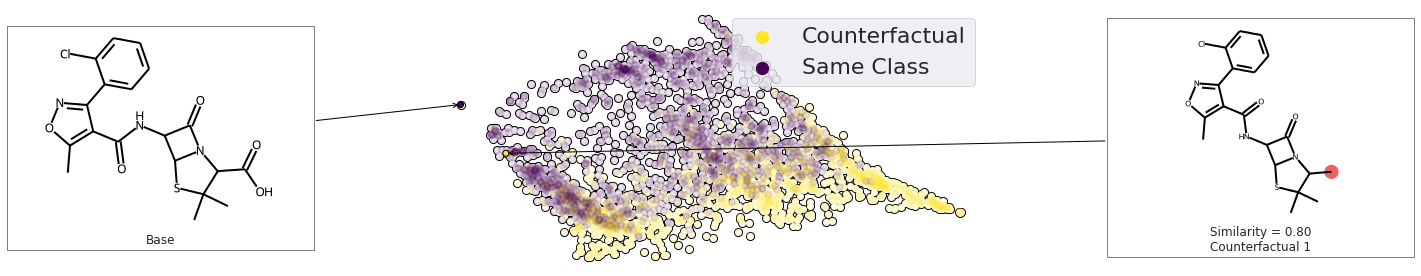

In [14]:
fkw = {'figsize': (8,4)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22,
       'dpi': 300}
exmol.plot_space(space, exps[:2], figure_kwargs=fkw, mol_size=(300,200), offset=0, cartoon=True)
plt.scatter([], [], label='Counterfactual', s=150, color=plt.get_cmap('viridis')(1.0))
plt.scatter([], [], label='Same Class', s=150, color=plt.get_cmap('viridis')(0.0))
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig('rf-schem-3.png', bbox_inches='tight', dpi=180)
svg = exmol.insert_svg(exps[:2], mol_fontsize=10)
with open('rf-scheme.svg', 'w') as f:
    f.write(svg)
skunk.display(svg)

## Chemed

In [7]:
cspace = exmol.sample_space('Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C', 
                            model_eval,preset="medium")

🤘Done🤘: 100%|██████████| 2770.0/2770 [00:20<00:00, 133.79it/s]             


In [7]:
kws = {'num_samples':1500}
zspace = exmol.sample_space('Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C', 
                            model_eval, preset='chemed', method_kwargs=kws)

😀Calling your model function😀:  94%|█████████▍| 1417/1500 [00:02<00:00, 499.37it/s]

/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


😀Calling your model function😀:  94%|█████████▍| 1417/1500 [00:19<00:00, 499.37it/s]

/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


🤘Done🤘: 100%|██████████| 1417.0/1417 [00:05<00:00, 266.47it/s]                     


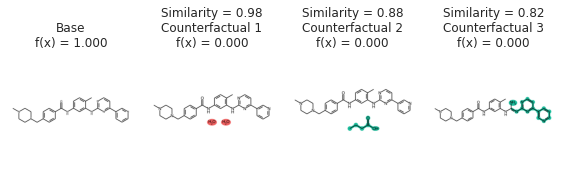

In [9]:
### Gleevac molecule
exps = exmol.cf_explain(zspace)
fkw = {'figsize': (8,6)}
mpl.rc('axes', titlesize=12)
exmol.plot_cf(exps, figure_kwargs=fkw, mol_size=(450,400), nrows=1)

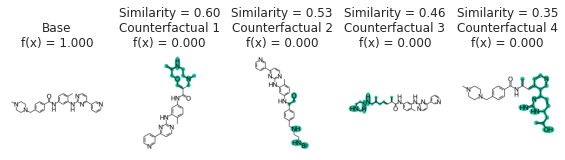

In [8]:
fkw = {'figsize': (8,6)}
mpl.rc('axes', titlesize=12)
cfs = exmol.cf_explain(cspace, nmols=4)
exmol.plot_cf(cfs, figure_kwargs=fkw, mol_fontsize=26, mol_size=(400,400), nrows=1)
svg = exmol.insert_svg(cfs)
with open('svg_figs/gleevac-cs.svg', 'w') as f:
    f.write(svg)
skunk.display(svg)
#plt.savefig('gleevac-cs.png', bbox_inches='tight', dpi=180)

In [ ]:
fkw = {'figsize': (8,6)}
mpl.rc('axes', titlesize=12)
exmol.plot_cf(exps, figure_kwargs=fkw, mol_size=(450,400), nrows=1)

#plt.savefig('rf-simple.png', dpi=180)
svg = exmol.insert_svg(exps, mol_fontsize=14)
with open('svg_figs/gleevac-simple.svg', 'w') as f:
    f.write(svg)

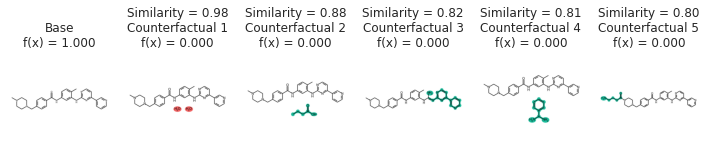

In [17]:
fkw = {'figsize': (10,6)}
mpl.rc('axes', titlesize=12)
exmol.plot_cf(exps, figure_kwargs=fkw, mol_size=(450,400), nrows=1)

zexps = exmol.cf_explain(zspace, nmols=5)
svg = exmol.insert_svg(zexps)

with open('svg_figs/gleevac-c.svg', 'w') as f:
    f.write(svg)
skunk.display(svg)
#plt.savefig('gleevac-c.png', bbox_inches='tight', dpi=180)